In [51]:
#Loading all the required Library for this Module

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

Reading all the Time Series Dataset .The above time series shows the fluctuation of Pressure in Desorption Chamber

In [ ]:

dateparse = lambda dates: pd.datetime.strptime(dates, '%d-%m-%Y')
df = pd.read_csv("Time_series_BTP.csv", parse_dates=["Time"] , index_col="Time",date_parser=dateparse)
cols = ['Unnamed: 2', 'Unnamed: 3' , 'Unnamed: 4']
df.drop(cols, axis=1, inplace=True)
y = df.PT_103.resample('W').mean()

Lets see how the original time-series look like.

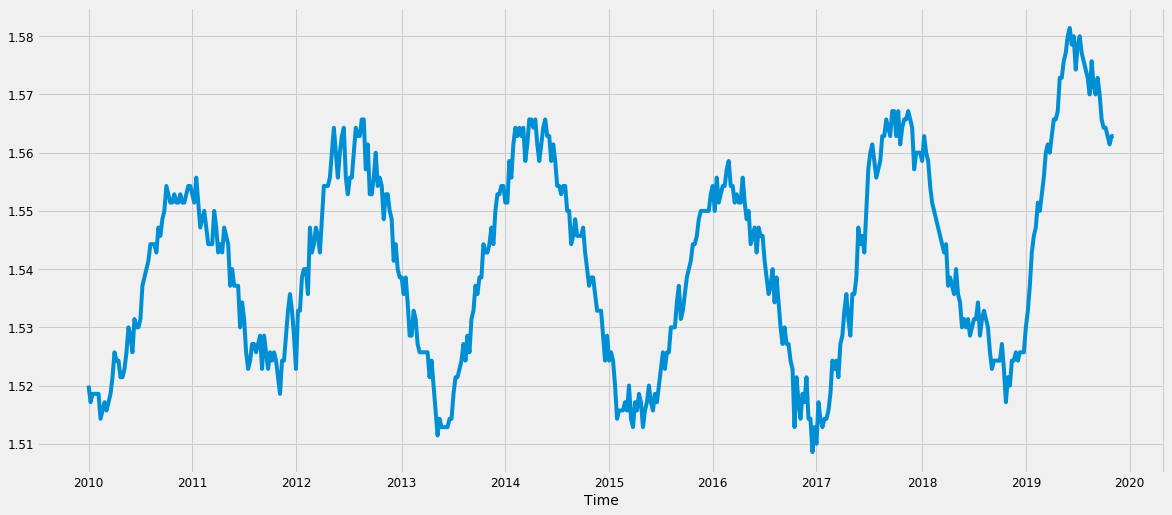

In [172]:
y.plot()
plt.show()



So the above time series follows the sinusoidal trend with trend slightly increasing trend.Lets varify it by decomposing it the series into Trend ,Seasonality and Residual values.

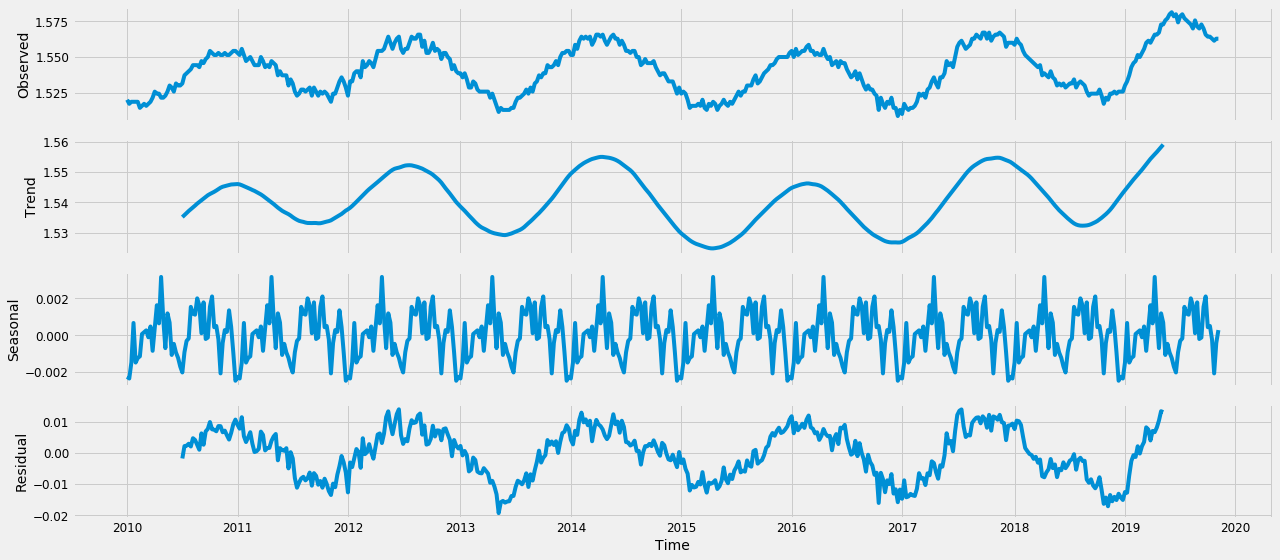

In [173]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

So as mentioned above it can be seen that the trend is sinusoidal with some seasonality pattern.

The assumptions of model of time series is that the time series should be stationary.We can check that by Dickey-Fuller and KPSS models.

In [174]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

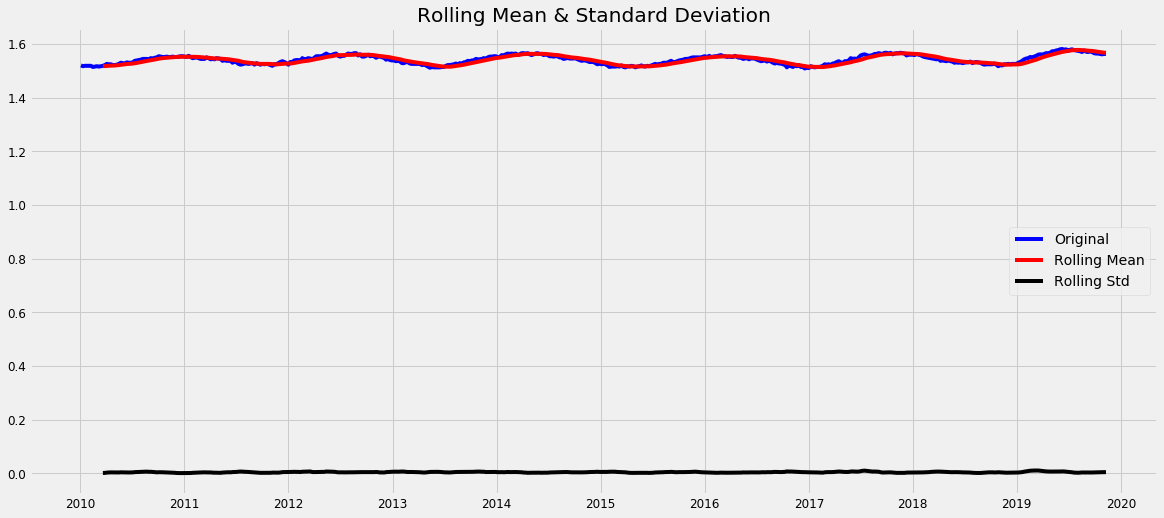

Results of Dickey-Fuller Test:
Test Statistic                -7.409872e+00
p-value                        7.181031e-11
#Lags Used                     1.700000e+01
Number of Observations Used    4.970000e+02
Critical Value (1%)           -3.443576e+00
Critical Value (5%)           -2.867373e+00
Critical Value (10%)          -2.569877e+00
dtype: float64


In [175]:
test_stationarity(y)

In [176]:
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [177]:
kpss_test(y)
#Above test statistics is less than the critical value hence we fail to reject null hypothesis.Hence the series is stationary.

Results of KPSS Test:
Test Statistic            0.168087
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


For Getting Best Result from modelling the time series we need to remove all the trend present in data.Since the trend in original time series looks bit positive we will penalize larger values  by using log transformation.

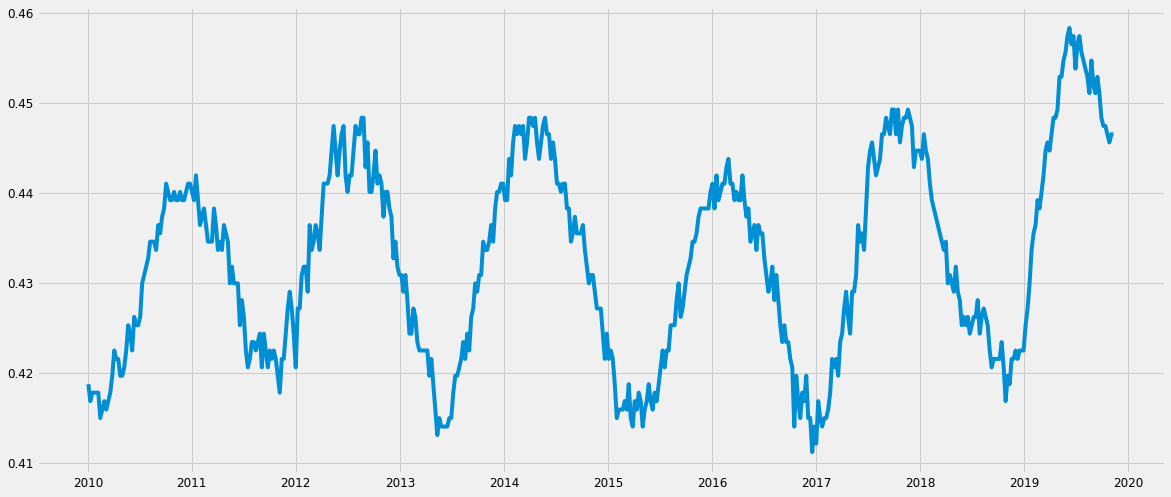

In [180]:
#Lets look at the results after eliminating the trend from the series 


ts_log = np.log(y)
plt.plot(ts_log)



We also implemented the method of moving average further to remove the remaineing trends.

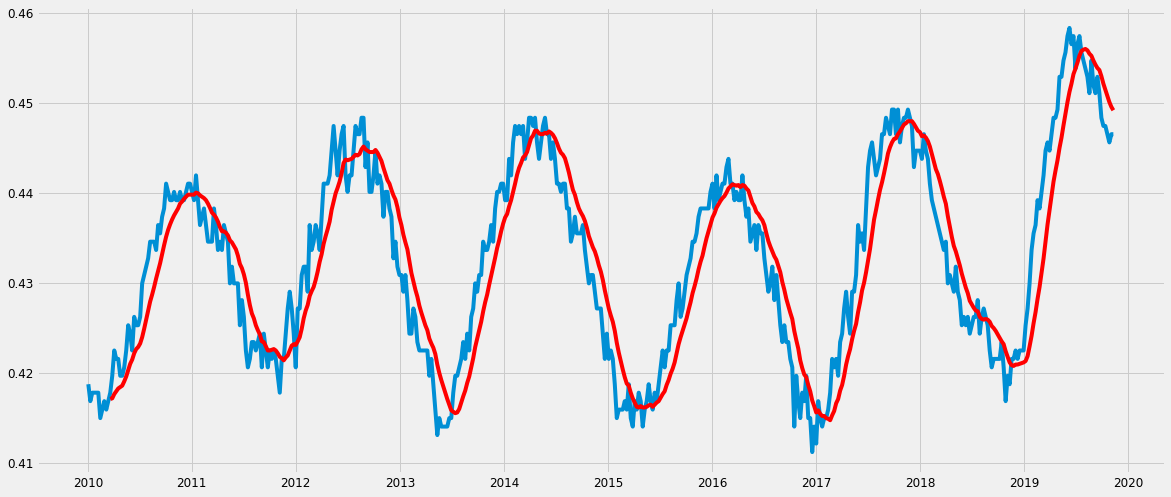

In [181]:
#Moving Average Method for removing Trend.
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [182]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Time
2010-01-03         NaN
2010-01-10         NaN
2010-01-17         NaN
2010-01-24         NaN
2010-01-31         NaN
2010-02-07         NaN
2010-02-14         NaN
2010-02-21         NaN
2010-02-28         NaN
2010-03-07         NaN
2010-03-14         NaN
2010-03-21    0.000706
Freq: W-SUN, Name: PT_103, dtype: float64

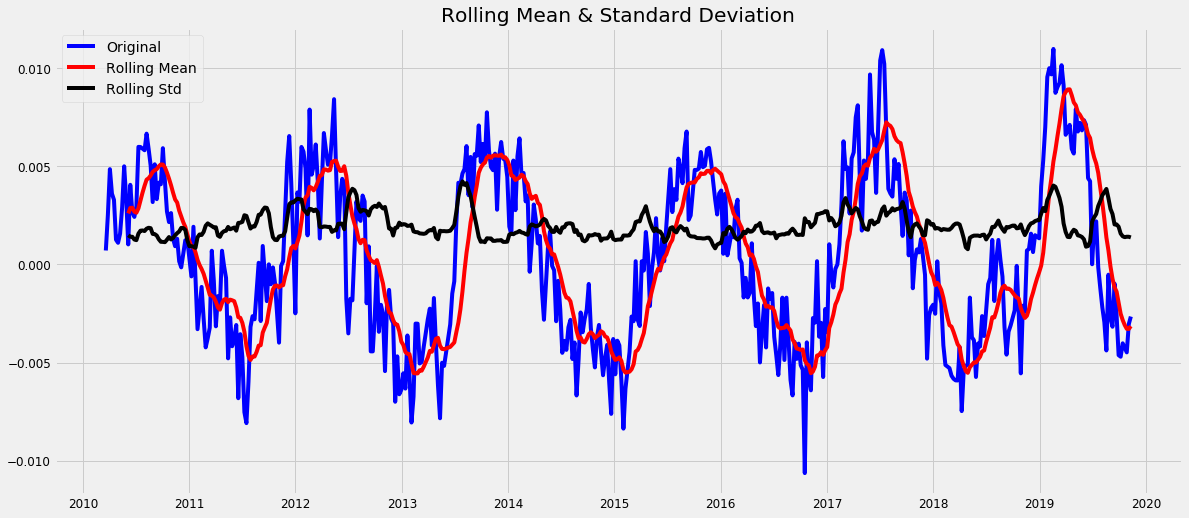

Results of Dickey-Fuller Test:
Test Statistic                  -5.111458
p-value                          0.000013
#Lags Used                      17.000000
Number of Observations Used    486.000000
Critical Value (1%)             -3.443877
Critical Value (5%)             -2.867505
Critical Value (10%)            -2.569947
dtype: float64


In [183]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

After removing all the trends in the dataset we get the following redefined timeseries.

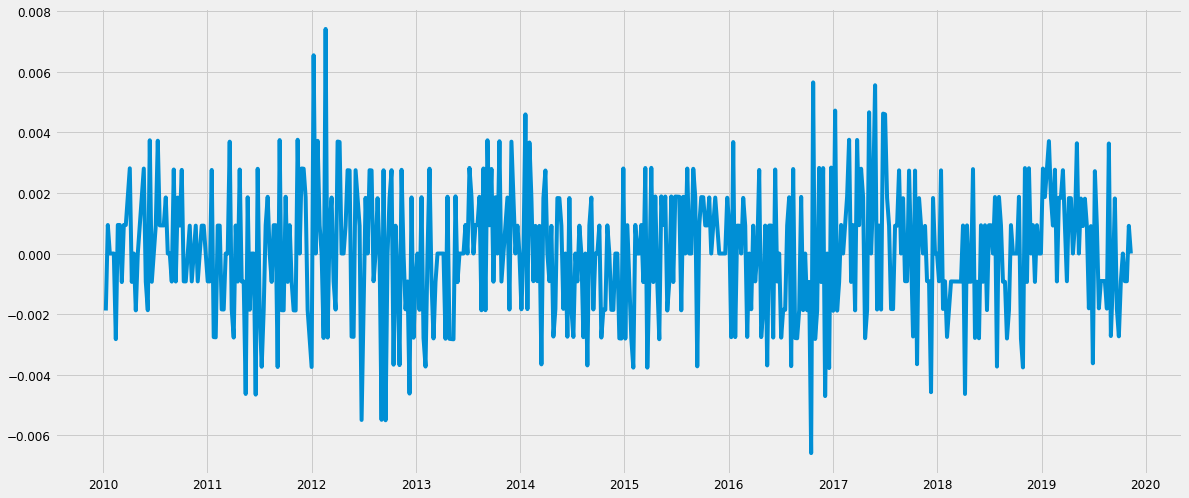

In [184]:
#Differencing Method for removing trends 

ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)


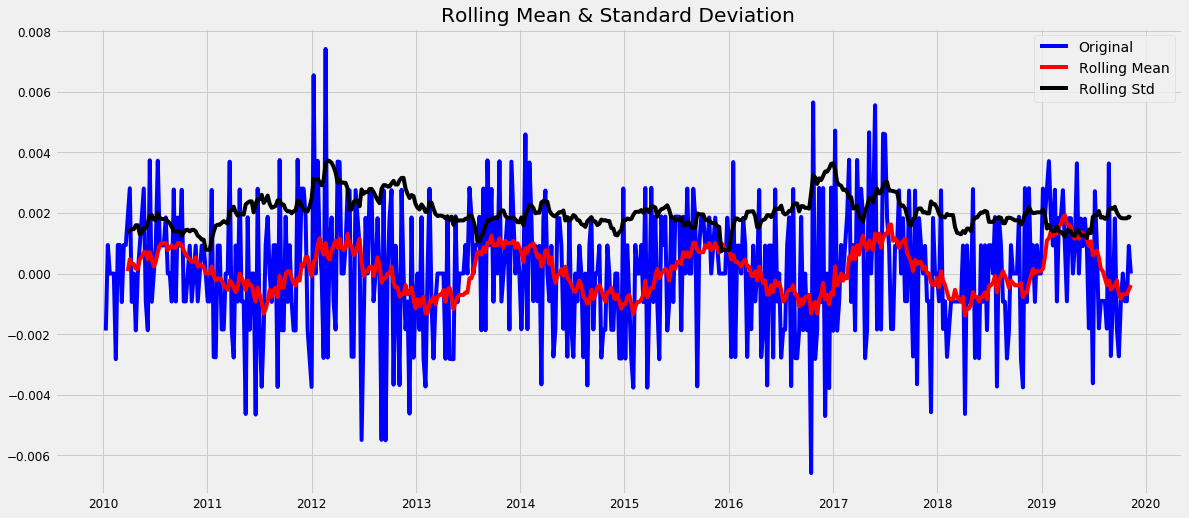

Results of Dickey-Fuller Test:
Test Statistic                  -3.611295
p-value                          0.005549
#Lags Used                       9.000000
Number of Observations Used    504.000000
Critical Value (1%)             -3.443392
Critical Value (5%)             -2.867292
Critical Value (10%)            -2.569833
dtype: float64


In [185]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

ARIMA MODELLING FOR FORECASTING

In [189]:
from statsmodels.tsa.stattools import acf, pacf

In [190]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Finding the parameters of ARIMA modelling by using ACF-PACF plots

Text(0.5,1,'Autocorrelation Function')

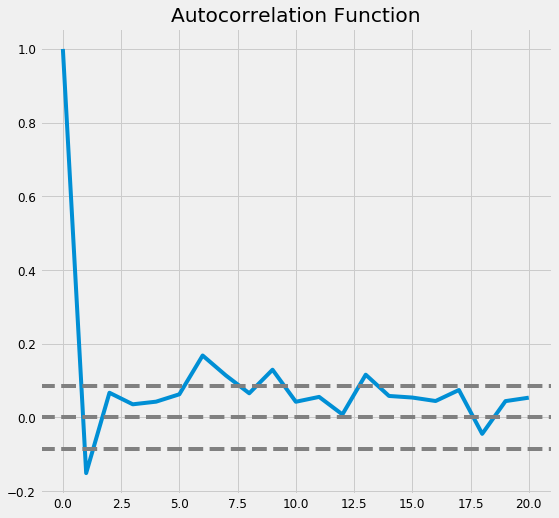

In [191]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

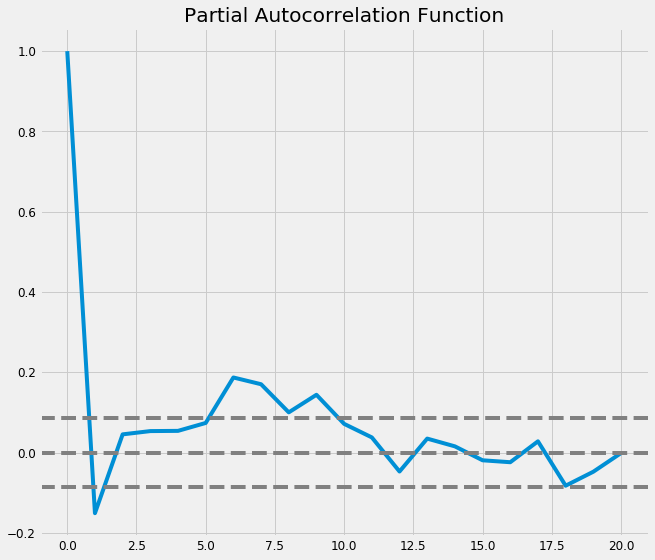

In [192]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

First we forecast using Auto-Regressive Modelling then with Moving Average Model and  finally combine them to obtain our best result with ARIMA modelling.

1.Auto-Regressive Model::::Implementation::::

Text(0.5,1,'RSS: 0.0022')

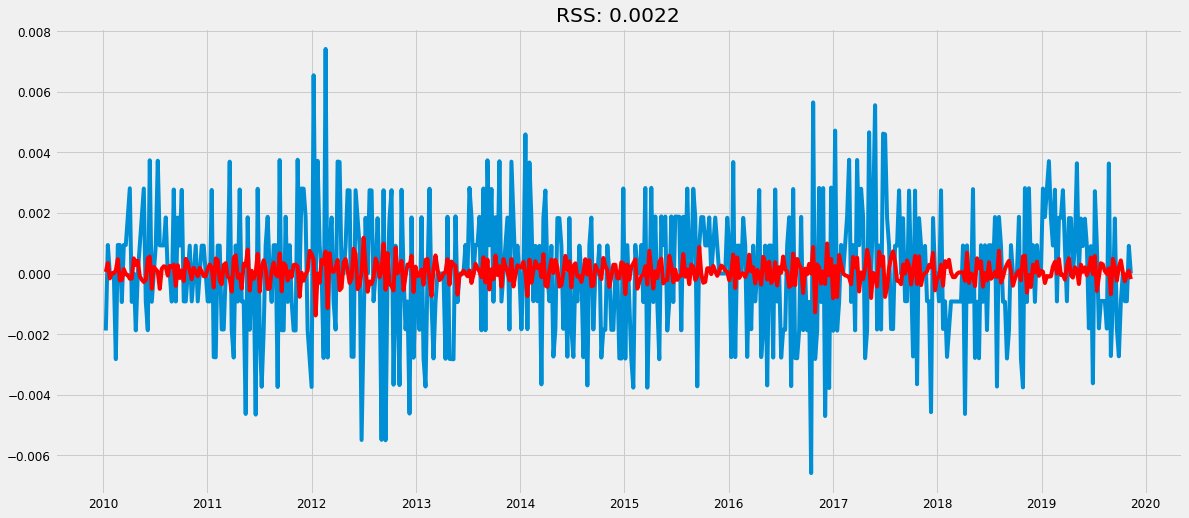

In [193]:
model = ARIMA(ts_log, order=(4, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

So the following model returns residual sum square of 0.0022

In [105]:
from statsmodels.tsa.arima_model import ARIMA

Lets try Moving Average model

Text(0.5,1,'RSS: 0.0022')

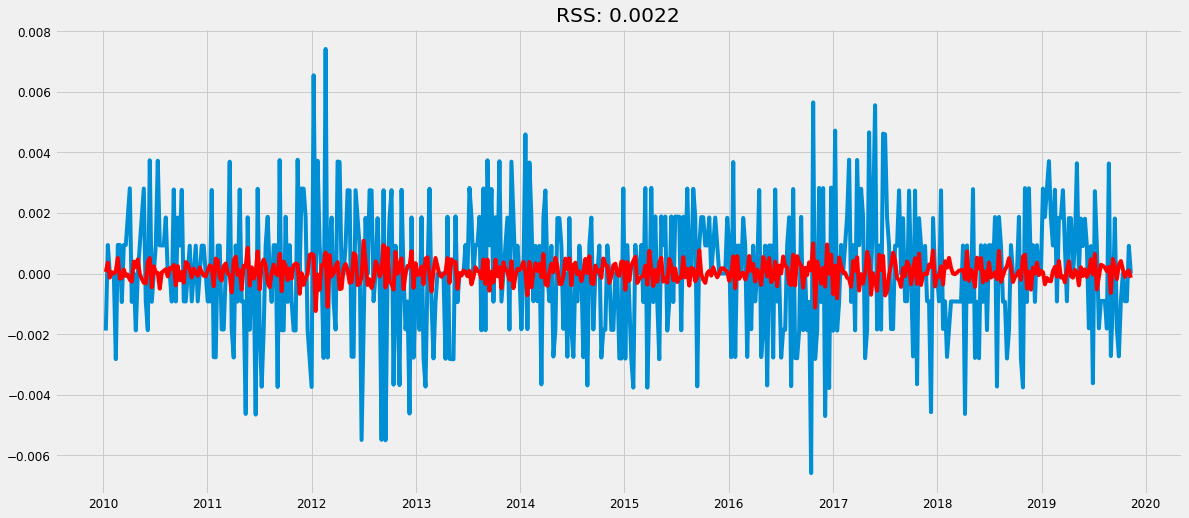

In [194]:
model = ARIMA(ts_log, order=(0, 1, 4))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

Somewhat similar to what we got earlier.Still no improvement over our first forecasting model.Finally we will implement model whic incorporate both AR and MA modelling known as ARIMA Modelling.

::::ARIMA MODELLING::::

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'RSS: 0.0020')

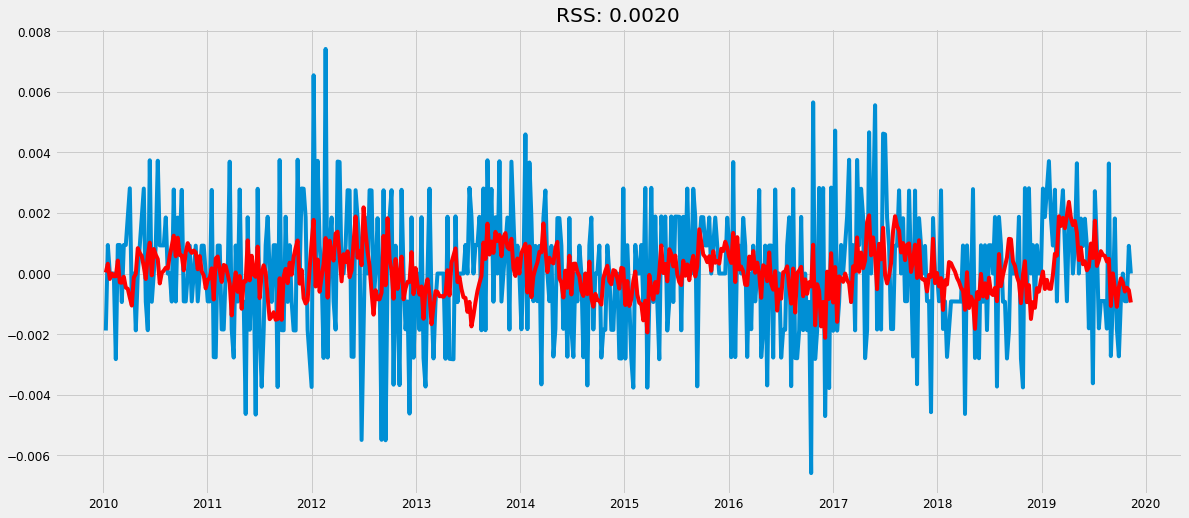

In [198]:
model = ARIMA(ts_log, order=(4, 1, 4))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [199]:
#Lets convert the entire series in Original one.
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head() )


Time
2010-01-10    0.000035
2010-01-17    0.000323
2010-01-24   -0.000180
2010-01-31   -0.000002
2010-02-07   -0.000090
Freq: W-SUN, dtype: float64


In [200]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head() )

Time
2010-01-10    0.000035
2010-01-17    0.000358
2010-01-24    0.000178
2010-01-31    0.000176
2010-02-07    0.000086
Freq: W-SUN, dtype: float64


In [201]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Time
2010-01-03    0.418710
2010-01-10    0.418745
2010-01-17    0.419068
2010-01-24    0.418889
2010-01-31    0.418887
Freq: W-SUN, dtype: float64

Text(0.5,1,'RMSE: 0.0115')

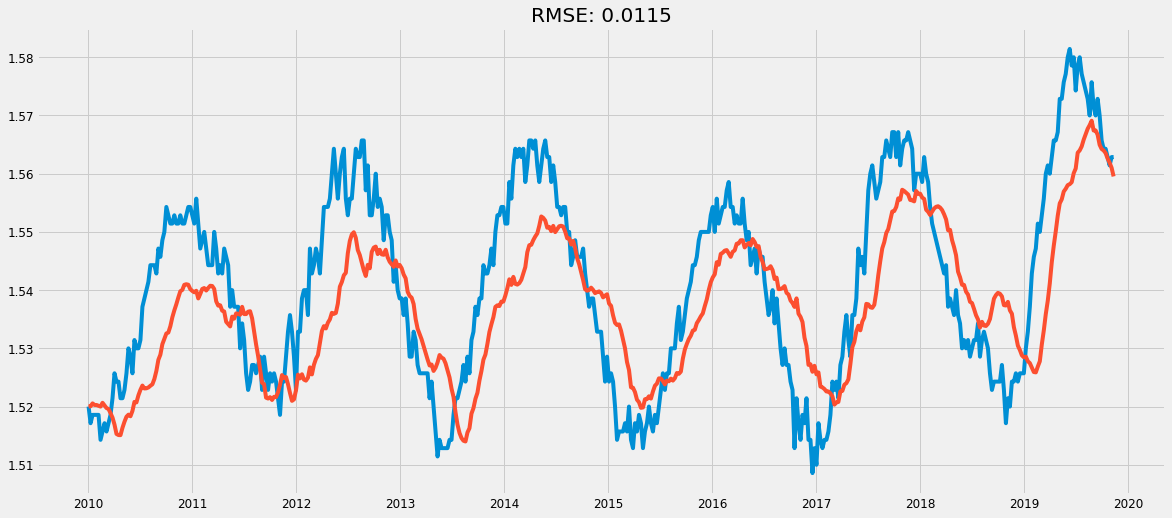

In [202]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(y)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-y)**2)/len(y)))

Here the Red one signifies the fitted values #Forecasted value .

We will implement one another forecasting method known as SARIMAX
An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA.

In [203]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [204]:
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1444      0.042     -3.421      0.001      -0.227      -0.062
ma.S.L12       0.0262      0.041      0.645      0.519      -0.053       0.106
sigma2      1.042e-05   6.71e-07     15.516      0.000     9.1e-06    1.17e-05


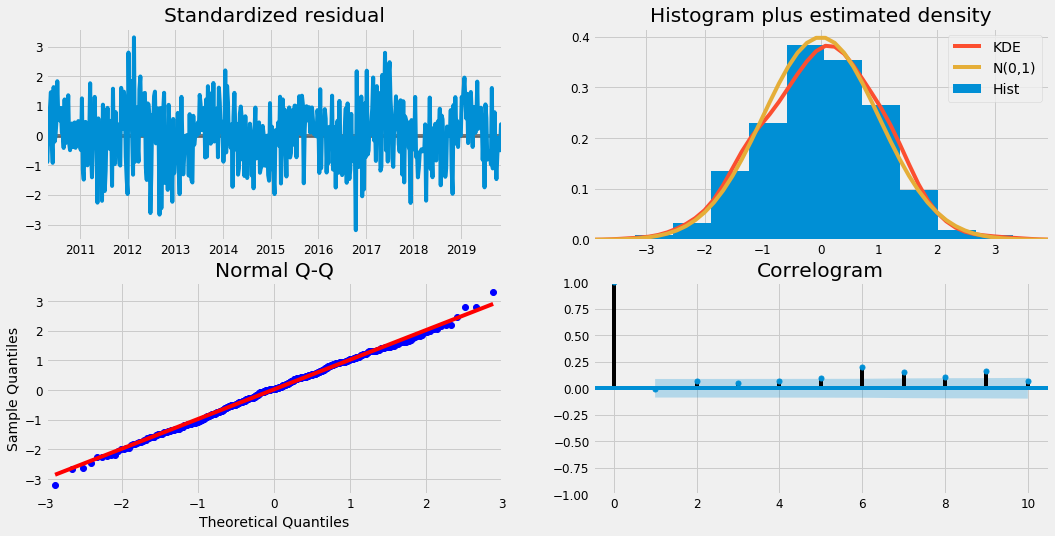

In [205]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

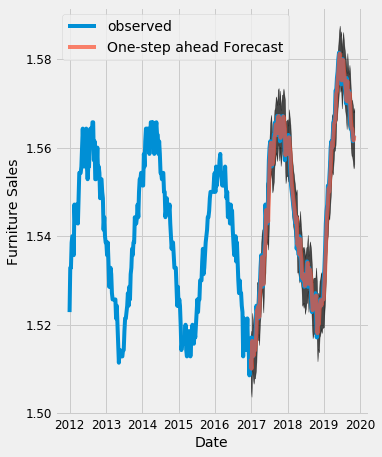

In [206]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(5, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()